**Table of contents**<a id='toc0_'></a>    
- 1. [Problem 1: Optimal taxation with government consumption](#toc1_)    
- 2. [Problem 2: Labor adjustment costs](#toc2_)    
- 3. [Problem 3: Global optimizer with refined multi-start](#toc3_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

## 2. <a id='toc2_'></a>[Problem 2: Labor adjustment costs](#toc0_)

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt

# Autoreload modules when code is run
%load_ext autoreload
%autoreload 2

# Local modules
import questiontwo
from questiontwo import *

You own a hair salon. You employ hairdressers, $\ell_t$, to produce haircuts, $y_t = \ell_t$.

The wage for each haridresser is $w$.

The demand for haircuts implies that the price of haircuts you can charge is $p_t = \kappa_t y_t^{-\eta}$, where $\kappa_t$ is a demand-shock and $\eta \in (0,1)$ measures the elasticity of demand.

Profits are:

$$
\Pi_t = p_t y_t - w \ell_t = \kappa_t \ell_t^{1-\eta} - w \ell_t
$$

Baseline parameters are:
- $\eta = 0.5$
- $w = 1.0$

**Question 1:** Verify numerically that $\ell_{t}=\left(\frac{(1-\eta)\kappa_{t}}{w}\right)^{\frac{1}{\eta}}$ maximises profits, for $\kappa\in\left\{1.0 , 2.0\right\}$.

*To numercially varify the level of labour that maximizes profits, we run a simulation for each kappa. We check the optimal level of labour following the suggested policy and the profit at this level of labor. Lastly, we compare this with this profit with profits stemming from 100 different levels of labour around the level found by the policy.*

*As expected, we find that the policy maximizes profits in both cases.*

In [2]:
# 1. setting up parameters
par = questiontwo.par
kappa_discrete = [1.0, 2.0]

# 2. running simulation with discrete kappa
for kappa in kappa_discrete:
    l_optimal = optimal_l(par, kappa)
    profit_optimal = profit(par, kappa, l_optimal)

    l_values = np.linspace(0.5 * l_optimal, 2 * l_optimal, 100)
    profits = [profit(par, kappa, l) for l in l_values]

    print(f"For kappa = {kappa}:")
    print(f"Optimal l: {l_optimal}")
    print(f"Profit at optimal l: {profit_optimal}")
    print(f"Max profit computed: {max(profits)}")
    print()

For kappa = 1.0:
Optimal l: 0.25
Profit at optimal l: 0.25
Max profit computed: 0.25

For kappa = 2.0:
Optimal l: 1.0
Profit at optimal l: 1.0
Max profit computed: 1.0



We now consider a *dynamic* version of the model.

* The demand-shock is a so-called AR(1) in logs, 

$$
\log \kappa_{t} = \rho \log \kappa_{t-1} + \epsilon_{t},\,\,\, \epsilon_{t+1} \sim \mathcal{N}(-0.5\sigma_{\epsilon}^2,\sigma_{\epsilon})
$$

* Any hiring or firing implies a fixed adjustment cost, $\iota > 0 $.
* Future profits are discounted with a monthly factor of $R \in (0,1)$.

The initial demand shock is $\kappa_{-1} = 1$ and the planning horizon is 10 years, i.e. 120 months so $t \in \{0,1,2,\dots,119\}$. Initially you don't have any employees, $\ell_{-1}=0$


The *ex post* value of the salon is *conditional* on the shock series is:

$$
h(\epsilon_0,\epsilon_1,\dots,\epsilon_{119}) = \left[\sum_{t=0}^{119}R^{-t}\left[\kappa_{t}\ell_{t}^{1-\eta}-w\ell_{t}-\boldsymbol{1}_{\ell_{t}\neq\ell_{t-1}}\iota\right]\right]
$$

The *ex ante* expected value of the salon can be approximated by

$$
H = \mathbb{E}[h(\epsilon_0,\epsilon_1,\dots,\epsilon_{119})] \approx \frac{1}{K}\sum_{k=0}^{K} h(\epsilon_0^k,\epsilon_1^k,\dots,\epsilon_{119}^k)
$$

where each $k\in\{0,1,\dots,K-1\}$ is a random shock series. Maximizing profitability means maximizing $H$.


Baseline parameters are: 

- $\rho = 0.90$
- $\iota = 0.01$
- $\sigma_{\epsilon} = 0.10$
- $R = \left(1+0.01\right)^{1/12}$

**Question 2:** Calculate $H$ if the policy  $\ell_{t}=\left(\frac{(1-\eta)\kappa_{t}}{w}\right)^{\frac{1}{\eta}}$ from question 1 is followed. Choose $K$ so the approximation is good enough to not affect your results substantially.

*We calculate H when the labour policy is followed by starting with $K=35$ simulations and increasing K until the relative size of the confidence interval is small enough (5 pct. is chosen as threshold).*

*On average after 10 runs, we find this to be true after $K=49$ simulations, which yields an (ex ante) expected value of the hair salon over 10 years to be $H=27.31$.*

In [3]:
# 1. Setting up empty lists for storing values of K and H
K_values = []
H_values = []

# 2. choosing a required precision level
epsilon = 0.05

# 3. Run simulation 10 times
for i in range(10):
    # 3.1 Start with a small K
    K = 35
    # 3.2 Setting up an empty list for storing the local value of H
    H_value = []
    while True:
        for k in range(K):
            # Change the seed for each simulation
            seed = (i + 1) * (k + 1)
            # Generate h for each run
            H_value.append(function_call(par, seed))
        
        # 3.3 Calculate mean and standard deviation
        mean_H = np.mean(H_value)
        std_H = np.std(H_value)
        conf_interval = 1.96 * std_H / np.sqrt(K)  # 95% confidence interval
        
        # 3.4 Break the loop if the relative size of the confidence interval is small enough
        if conf_interval / np.abs(mean_H) < epsilon:  # with 5 pct. precision
            break
        
        # 3.5 Increase K for the next iteration
        K += 1
    # 3.6 append the values of K and H to the lists  
    K_values.append(K)
    H_values.append(mean_H)

# 4. Print the mean result of K after 10 simulations
print(f"To find the average expected value of the salon of H = {np.mean(H_values):.2f} on")
print(f"average K={np.mean(K_values):.0f} simulations were needed to not change H significantly.")

To find the average expected value of the salon of H = 27.31 on
average K=49 simulations were needed to not change H significantly.


Next, we consider policies on the form:

$$

\ell_{t}=\begin{cases}
\ell_t^{\ast}  & \text{if }\left|\ell_{t-1}-\ell_t^{\ast} \right|>\Delta\\
\ell_{t-1} & \text{else }
\end{cases}
\\
\text{where}\,\,\ell_t^{\ast} = \left(\frac{(1-\eta)\kappa_{t}}{w}\right)^{\frac{1}{\eta}} \\

$$
With $\Delta \geq 0$ and $\Delta = 0$ being the previous policy.



**Question 3:** Calculate $H$ if the policy above was followed with $\Delta = 0.05$. Does it improve profitability?

*We introduce the new policy and compare the mean profitability (over $K=49$, as found before) of each policy {old,new} over 10 simulations.* 

*We find that the new policy helps mitigating the problem with adjustment costs and thereby improves profitability with about 2.5 pct.*

In [4]:
# 1. introducing new parameter Delta
#par.Delta = 0.05

# 2. setting up an empty list for storing the improvement in H for the new policy
H_Delta = [] 
improvement = []

# 3. runing the simulation 10 times
for i in range(10):
    # 3.1 run simulations for new policy
    # setting up an empty list for storing the values of H for the new policy
    H_values_new = []
    for k in range(par.K):
        # setting new seed for each run and changing Delta
        seed = (i + 1) * (k + 1)
        par.Delta = 0.05
        # Generate h for each run
        H_values_new.append(function_call(par, seed))

    # calculate mean H for new policy
    H_new = np.mean(H_values_new)

    # saving the value of H for the new policy
    H_Delta.append(H_new)

    # 3.3 calculate the improvement
    improvement.append(H_new - np.mean(H_values))

# Print results
print(f'On average, the new policy improves profitability with {np.mean(improvement):.2f}.')


On average, the new policy improves profitability with 0.61.


**Question 4:** Find the optimal $\Delta$ maximizing $H$. Illustrate your result.

*In order to find the optimal level of $\Delta$ maximizing $H$ we loop over 100 different levels of $\Delta$ from $[0,0.2]$ simulating $H$ each time.*

*We find that $\Delta=0.07$ on average maximizes profits.*

The mean best Delta value over 10 runs is 0.07.


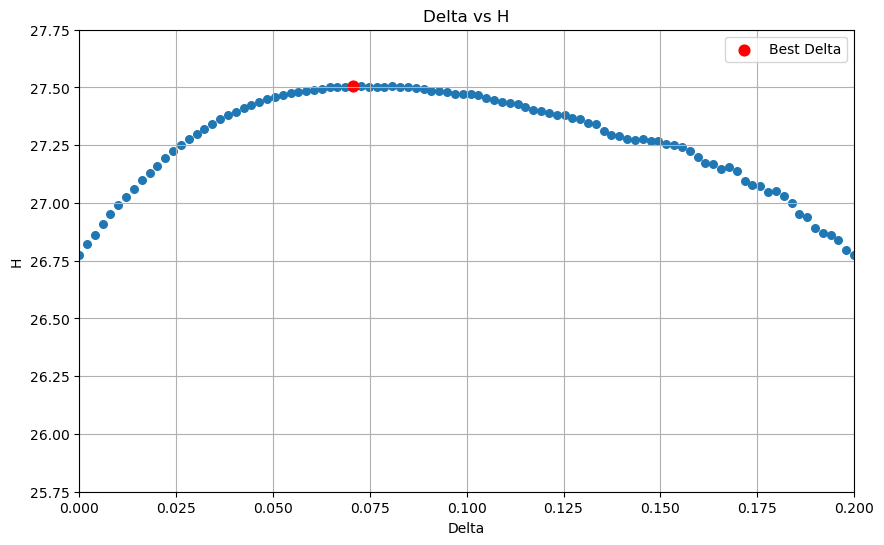

In [5]:
# 1. setting up an empty list for storing the values of Delta and H
Deltas = []
H_values_deltas = []
max_H_new = float('-inf')

# 2. simulating over a range of 500 Deltas between 0.0 and 0.4
for Delta in np.linspace(0, 0.20, 100):

    # Setting up an empty list for storing the values of H
    H_values_new = []
    for k in range(par.K):
        # Set new seed for each run and change Delta
        seed = (i + 1) * (k + 1)
        par.Delta = Delta
        # Generate h for each run
        H_values_new.append(function_call(par, seed))

    # Calculate H for new policy
    H_new = np.mean(H_values_new)
    
    # Append the values of Delta and H to the lists
    Deltas.append(Delta)
    H_values_deltas.append(H_new)
    
    # update the best Delta if the new H is higher than the previous best
    if H_new > max_H_new:
        max_H_new = H_new
        best_Delta = Delta
            
# 3. print results    
print(f"The mean best Delta value over 10 runs is {best_Delta:.2f}.")

# 4. Plot Delta vs H
plt.figure(figsize=(10, 6))
plt.scatter(Deltas, H_values_deltas, s=30)  # Reduce the size of dots with s parameter
plt.xlabel("Delta")
plt.ylabel("H")
plt.title("Delta vs H")
plt.xlim(0, 0.2)  # Set the x-axis limits
plt.ylim(25.75, 27.75)  # Set the y-axis limits
plt.grid(True)

# 5. mark the best Delta with a red dot
best_index = H_values_deltas.index(max_H_new)
plt.scatter(Deltas[best_index], H_values_deltas[best_index], c='red', label='Best Delta',s=60)
plt.legend()

plt.show()



**Question 5:** Suggest an alternative policy you believe might improve profitability. Implement and test your policy.

*We suggest and implement a policy of having part time employees as buffers, such that these employees could be adjusted in working hours dynamically after shocks are realized. For instance, think about a situation where in a period with a moderate negative shock it would be optimal to fire 0.6 employees. Normally, that would entail firing costs of $\iota$. By instead lowering the hours of the employee, we don't need to fire the person. In our setup we accept that there would still be adjustment costs, ie. that could be compensation to the employee, but only of $0.6 \cdot \iota$.*

*Our extention improves profitability with 1.3 against the situation without any policy in place, equivalent to: 4.8 pct., and with 0.69 against the policy with an optimal $\Delta=0.07$, equivalent to: 2.5 pct.*

In [12]:
# 1. restoring Delta to 0
par.Delta=0

# 2. setting up an empty list for storing the values improvement in H for no policy or optimal Delta policy
improvement_no_policy = []
improvement_optimal_Delta = []

# 2. runing the simulation 50 times
for i in range(50):
    # Run simulations for the extention
    H_values_extention = []
    for k in range(par.K):
        seed = (i + 1) * (k + 1)
        H_values_extention.append(function_call(par, seed, extention=True))

    # Calculate H for the extention
    H_extention = np.mean(H_values_extention)

    #Improvement
    improvement_no_policy.append(H_extention - np.mean(H_values))
    improvement_optimal_Delta.append(H_extention - np.mean(H_Delta))

# Print results
print(f'On average, our new extention improves profitability with:')
print(f'   {np.mean(improvement_no_policy):.2f}, against the situation with no policy.')
print(f'   {np.mean(improvement_optimal_Delta):.2f}, against the situation with Delta=0.07.')

On average, our new extention improves profitability with:
   1.30, against the situation with no policy.
   0.69, against the situation with Delta=0.07.
